In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
import re
from math import sqrt
import os
import warnings

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,grangercausalitytests

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout, RNN
from keras_tuner import BayesianOptimization, RandomSearch, GridSearch
import keras

E:\Ananconda_Installation\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df_unemployment=pd.read_csv('Japan Dataset\DP_LIVE_18042023124659745.csv')
df_unemployment.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HUR,TOT,PC_LF,A,1967,1.875,NaN
1,AUS,HUR,TOT,PC_LF,A,1968,1.850,NaN
2,AUS,HUR,TOT,PC_LF,A,1969,1.800,NaN
3,AUS,HUR,TOT,PC_LF,A,1970,1.625,NaN
4,AUS,HUR,TOT,PC_LF,A,1971,1.925,NaN


In [3]:
df_unemployment_japan=df_unemployment[(df_unemployment['LOCATION']=='JPN')&(df_unemployment['SUBJECT']=='TOT')].copy()
df_unemployment_japan_men=df_unemployment[(df_unemployment['LOCATION']=='JPN')&(df_unemployment['SUBJECT']=='MEN')].copy()
df_unemployment_japan_women=df_unemployment[(df_unemployment['LOCATION']=='JPN')&
                                            (df_unemployment['SUBJECT']=='WOMEN')].copy()

In [4]:
df_unemployment_japan_monthly=df_unemployment_japan[df_unemployment_japan['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]
df_unemployment_japan_men_monthly=df_unemployment_japan_men[df_unemployment_japan_men['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]
df_unemployment_japan_women_monthly=df_unemployment_japan_women[df_unemployment_japan_women['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]

# 1. Baseline Model : Univariate Time Series ARIMA

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

Refer to hackathon23_somnolence\benchmark\ARIMA_Univariate\ARIMA_Univariate.ipynb

# 2. Multivariate Time Series Forecasting with LSTMs

## 2.1. DATA prep and EDA

### 2.1.1. Production and Labour IMF data

In [5]:
df_production_labour=pd.read_excel(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\imf\prices_production_and_labour\Prices_Production_and_Labor_Japan.xlsx',sheet_name='Monthly_Data')
df_production_labour['Indicator'].unique()

array(['Prices', 'Financial Market Prices, Equities, Index',
       'Prices, Producer Price Index, All Commodities, Index',
       'Prices, Consumer Price Index, All items, Index', 'Production',
       'Economic Activity, Industrial Production, Manufacturing, Index',
       'Economic Activity, Industrial Production, Index',
       'Industrial Production, Seasonally adjusted, Index', 'Labor',
       'Labor Markets, Wage Rates, Index',
       'Labor Force, Persons, Number of',
       'Employment, Persons, Number of',
       'Unemployment, Persons, Number of',
       'Labor Markets, Unemployment Rate, Percent'], dtype=object)

In [6]:
time_col=[col for col in df_production_labour.columns if re.search(r'\d{4}',str(col),re.I)!=None]

df_production_labour_restructured=pd.melt(df_production_labour,id_vars='Indicator',value_vars=time_col,var_name='timeframe')
df_production_labour_restructured=pd.pivot(df_production_labour_restructured,index='timeframe',columns='Indicator',values='value').reset_index()

df_production_labour_restructured['timeframe_year']=df_production_labour_restructured['timeframe'].str.split('M',expand=True)[0]
df_production_labour_restructured['timeframe_month']=df_production_labour_restructured['timeframe'].str.split('M',expand=True)[1]

df_production_labour_restructured['TIME']=df_production_labour_restructured['timeframe_year']+'-'+df_production_labour_restructured['timeframe_month']

df_production_labour_restructured.drop(columns=['timeframe','timeframe_month','timeframe_year','Prices'],inplace=True)

In [7]:
df_MRD=pd.merge(df_unemployment_japan_monthly,df_production_labour_restructured,on='TIME',how='left')
df_MRD['TIME']=pd.to_datetime(df_MRD['TIME'],format='%Y-%m')
df_MRD=df_MRD.set_index('TIME')

feature_col=['Economic Activity, Industrial Production, Index',
             'Economic Activity, Industrial Production, Manufacturing, Index',
             'Financial Market Prices, Equities, Index',
             'Industrial Production, Seasonally adjusted, Index',
             'Labor Markets, Wage Rates, Index',
             'Prices, Consumer Price Index, All items, Index']

target_col=['Value']

df_MRD=df_MRD[feature_col+target_col]
for col in df_MRD.columns:
    df_MRD[col]=pd.to_numeric(df_MRD[col],errors='coerce')

In [8]:
df_MRD.shape

(818, 7)

In [9]:
df_producer_price_index=pd.read_csv(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\oecd\Producer Price Index.csv')
df_producer_price_index=df_producer_price_index[(df_producer_price_index['LOCATION']=='JPN')&
                                                (df_producer_price_index['MEASURE']=='IDX2015')][['TIME','Value']]
df_producer_price_index=df_producer_price_index[df_producer_price_index['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]

df_producer_price_index['TIME']=pd.to_datetime(df_producer_price_index['TIME'],format='%Y-%m')
df_producer_price_index=df_producer_price_index.set_index('TIME')
df_producer_price_index.rename(columns={'Value':'Producer Price Index'},inplace=True)

df_producer_price_index['Producer Price Index']=pd.to_numeric(df_producer_price_index['Producer Price Index'],
                                                              errors='coerce')
df_MRD=pd.merge(df_MRD, df_producer_price_index, left_index=True, right_index=True, how='left')

### 2.1.2. OECD Consumer and Business Confidence Data

In [10]:
df_business_confidence=pd.read_csv(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\oecd\Business_Confidence_Index.csv')
df_consumer_confidence=pd.read_csv(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\oecd\Consumer_Confidence_Index.csv')

In [11]:
df_business_confidence=df_business_confidence[df_business_confidence['LOCATION']=='JPN'][['TIME','Value']]
df_business_confidence['TIME']=pd.to_datetime(df_business_confidence['TIME'],format='%Y-%m')
df_business_confidence=df_business_confidence.set_index('TIME')
df_business_confidence.rename(columns={'Value':'Business Confidence Index'},inplace=True)

df_consumer_confidence=df_consumer_confidence[df_consumer_confidence['LOCATION']=='JPN'][['TIME','Value']]
df_consumer_confidence['TIME']=pd.to_datetime(df_consumer_confidence['TIME'],format='%Y-%m')
df_consumer_confidence=df_consumer_confidence.set_index('TIME')
df_consumer_confidence.rename(columns={'Value':'Consumer Confidence Index'},inplace=True)

In [12]:
df_MRD=pd.merge(df_MRD, df_business_confidence, left_index=True, right_index=True, how='left')
df_MRD=pd.merge(df_MRD, df_consumer_confidence, left_index=True, right_index=True, how='left')

### 2.1.3. OPEC Import Data

### 2.1.4. GDP and Interest Rate IMF Data

In [13]:
df_interest_rates=pd.read_excel(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\imf\central_banking_interest_rates\Interest_Rates_Japan.xlsx',sheet_name='Monthly Data')

time_col=[col for col in df_interest_rates.columns if re.search(r'\d{4}',str(col),re.I)!=None]

df_interest_rates=pd.melt(df_interest_rates,id_vars='Indicator',value_vars=time_col,var_name='timeframe')
df_interest_rates=pd.pivot(df_interest_rates,index='timeframe',columns='Indicator',values='value').reset_index()

df_interest_rates['timeframe_year']=df_interest_rates['timeframe'].str.split('M',expand=True)[0]
df_interest_rates['timeframe_month']=df_interest_rates['timeframe'].str.split('M',expand=True)[1]

df_interest_rates['TIME']=df_interest_rates['timeframe_year']+'-'+df_interest_rates['timeframe_month']

df_interest_rates.drop(columns=['timeframe','timeframe_month','timeframe_year'],inplace=True)

df_interest_rates['TIME']=pd.to_datetime(df_interest_rates['TIME'],format='%Y-%m')
df_interest_rates=df_interest_rates.set_index('TIME')

for col in df_interest_rates.columns:
    df_interest_rates[col]=pd.to_numeric(df_interest_rates[col],errors='coerce')

In [14]:
df_gdp=pd.read_excel(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\imf\gross_domestic_product\GDP_and_Components_Japan.xlsx',sheet_name='Quarterly Data')

time_col=[col for col in df_gdp.columns if re.search(r'\d{4}',str(col),re.I)!=None]

df_gdp=pd.melt(df_gdp,id_vars='Indicator',value_vars=time_col,var_name='timeframe')
df_gdp=pd.pivot(df_gdp,index='timeframe',columns='Indicator',values='value').reset_index()

In [15]:
map_df=pd.DataFrame({'timeframe':[],'new_timeframe':[]})

for val in df_gdp['timeframe'].unique():
    val_year=val.split('Q')[0]
    val_quarter=int(val.split('Q')[1])
    start_month=val_quarter*3-2
    for month in range(start_month,start_month+3):   
        map_df=map_df.append({'timeframe':val,'new_timeframe':val_year+'-'+str(month)},ignore_index=True)
        
df_gdp=pd.merge(df_gdp,map_df,on='timeframe',how='inner')

C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  map_df=map_df.append({'timeframe':val,'new_timeframe':val_year+'-'+str(month)},ignore_index=True)
C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  map_df=map_df.append({'timeframe':val,'new_timeframe':val_year+'-'+str(month)},ignore_index=True)
C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  map_df=map_df.append({'timeframe':val,'new_timeframe':val_year+'-'+str(month)},ignore_index=True)
C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: Futur

C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  map_df=map_df.append({'timeframe':val,'new_timeframe':val_year+'-'+str(month)},ignore_index=True)
C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  map_df=map_df.append({'timeframe':val,'new_timeframe':val_year+'-'+str(month)},ignore_index=True)
C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  map_df=map_df.append({'timeframe':val,'new_timeframe':val_year+'-'+str(month)},ignore_index=True)
C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: Futur

C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  map_df=map_df.append({'timeframe':val,'new_timeframe':val_year+'-'+str(month)},ignore_index=True)
C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  map_df=map_df.append({'timeframe':val,'new_timeframe':val_year+'-'+str(month)},ignore_index=True)
C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  map_df=map_df.append({'timeframe':val,'new_timeframe':val_year+'-'+str(month)},ignore_index=True)
C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\2625611763.py:8: Futur

In [16]:
df_gdp['TIME']=pd.to_datetime(df_gdp['new_timeframe'],format='%Y-%m')
df_gdp=df_gdp.set_index('TIME')

df_gdp.drop(columns=['timeframe','new_timeframe'],inplace=True)

for col in df_gdp.columns:
    df_gdp[col]=pd.to_numeric(df_gdp[col],errors='coerce')

In [17]:
df_MRD=pd.merge(df_MRD, df_interest_rates, left_index=True, right_index=True, how='left')
df_MRD=pd.merge(df_MRD, df_gdp, left_index=True, right_index=True, how='left')

In [18]:
df_MRD

,"Economic Activity, Industrial Production, Index","Economic Activity, Industrial Production, Manufacturing, Index","Financial Market Prices, Equities, Index","Industrial Production, Seasonally adjusted, Index","Labor Markets, Wage Rates, Index","Prices, Consumer Price Index, All items, Index",Value,Producer Price Index,Business Confidence Index,Consumer Confidence Index,...,"Gross Fixed Capital Formation, Real, Seasonally Adjusted, Domestic Currency","Gross Fixed Capital Formation, Real, Undjusted, Domestic Currency","Household Consumption Expenditure, incl. NPISHs, Nominal, Seasonally Adjusted, Domestic Currency","Household Consumption Expenditure, incl. NPISHs, Nominal, Undjusted, Domestic Currency","Household Consumption Expenditure, incl. NPISHs, Real, Seasonally Adjusted, Domestic Currency","Household Consumption Expenditure, incl. NPISHs, Real, Undjusted, Domestic Currency","Imports of Goods and Services, Nominal, Seasonally Adjusted, Domestic Currency","Imports of Goods and Services, Nominal, Undjusted, Domestic Currency","Imports of Goods and Services, Real, Seasonally Adjusted, Domestic Currency","Imports of Goods and Services, Real, Undjusted, Domestic Currency"
TIME,,,,,,,,,,,,,,,,,,,,,
1955-01-01,NaN,NaN,NaN,NaN,NaN,NaN,2.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-02-01,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-03-01,NaN,NaN,NaN,NaN,NaN,NaN,2.3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-04-01,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-05-01,NaN,NaN,NaN,NaN,NaN,NaN,2.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,92.610696,93.561841,NaN,92.717228,NaN,109.368958,2.6,114.6096,100.531401,96.877525,...,33478375.0,34095200.0,78388750.0,80782800.0,73935675.0,75422400.0,37919600.0,38461500.0,28105225.0,28506400.0
2022-11-01,95.334540,96.397048,NaN,93.009098,NaN,109.579891,2.5,115.0096,100.569944,96.831894,...,33478375.0,34095200.0,78388750.0,80782800.0,73935675.0,75422400.0,37919600.0,38461500.0,28105225.0,28506400.0
2022-12-01,NaN,NaN,NaN,NaN,NaN,109.790824,2.5,115.2096,100.613472,96.924163,...,33478375.0,34095200.0,78388750.0,80782800.0,73935675.0,75422400.0,37919600.0,38461500.0,28105225.0,28506400.0


### 2.1.5. Scaling and Trend Analysis

In [19]:
scaler=MinMaxScaler()
df_MRD_scaled=scaler.fit_transform(df_MRD)
df_MRD_scaled=pd.DataFrame(df_MRD_scaled,columns=df_MRD.columns)

df_MRD_scaled.index=df_MRD.index

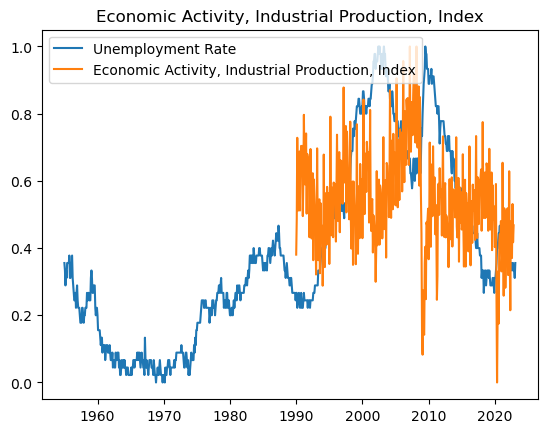

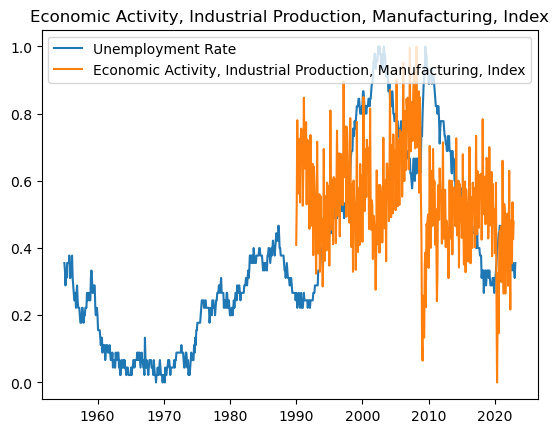

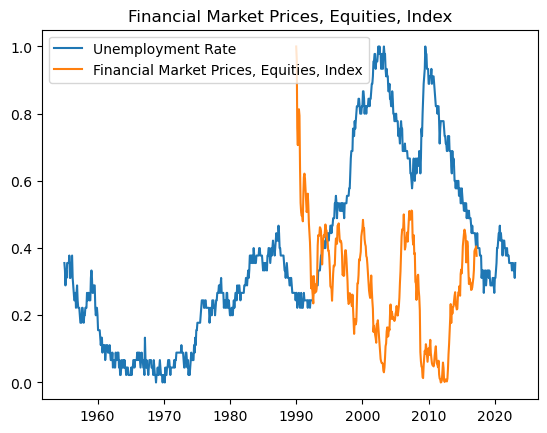

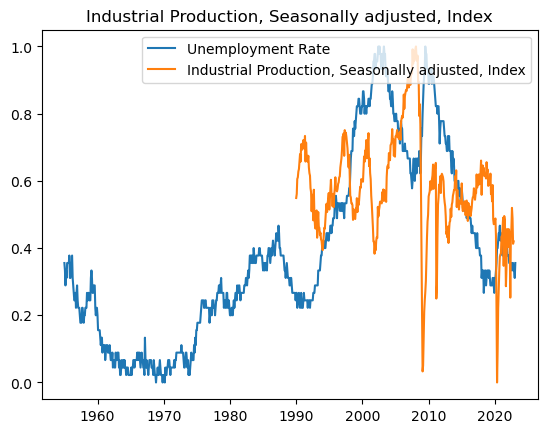

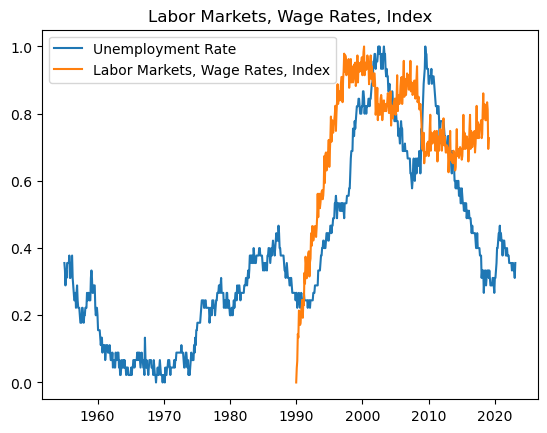

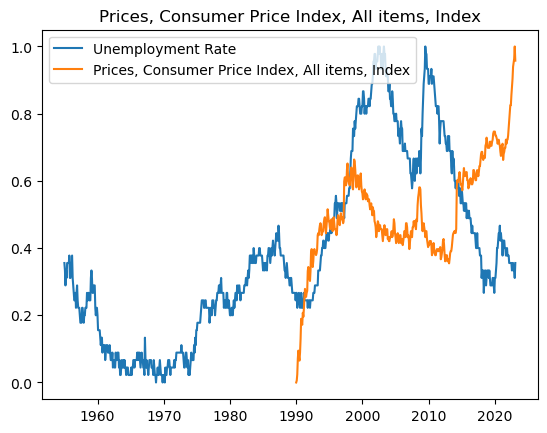

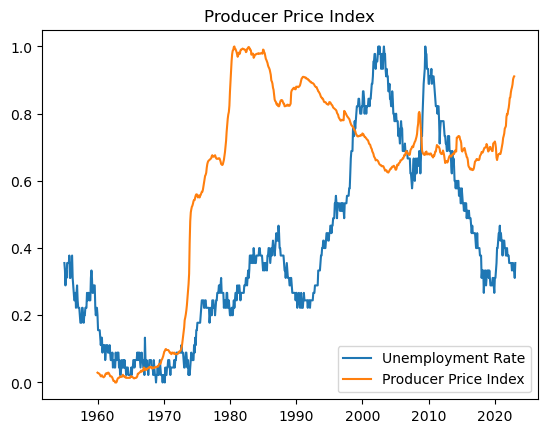

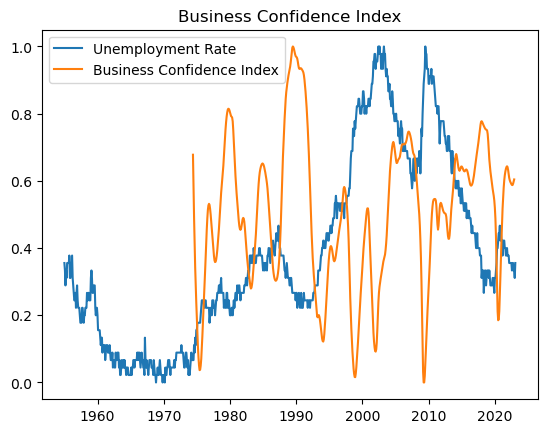

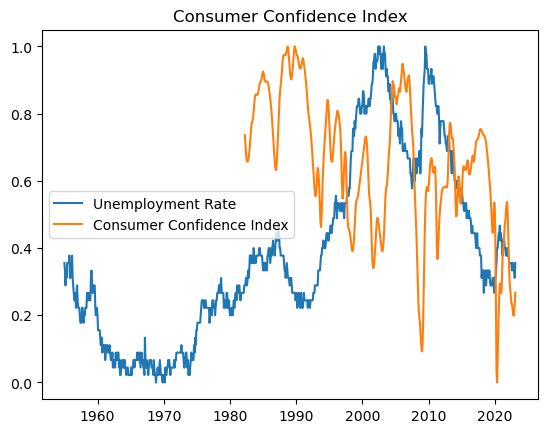

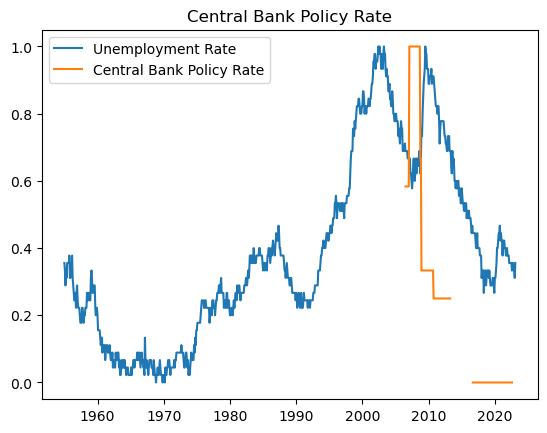

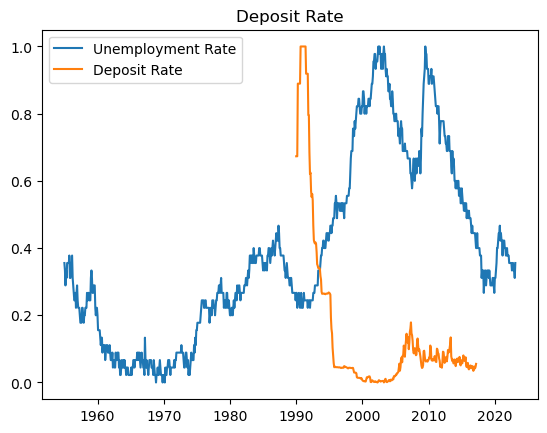

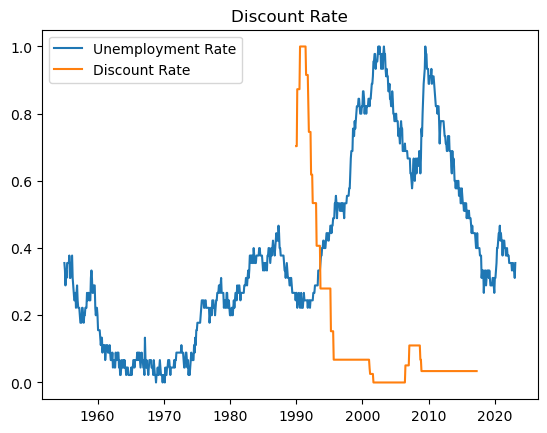

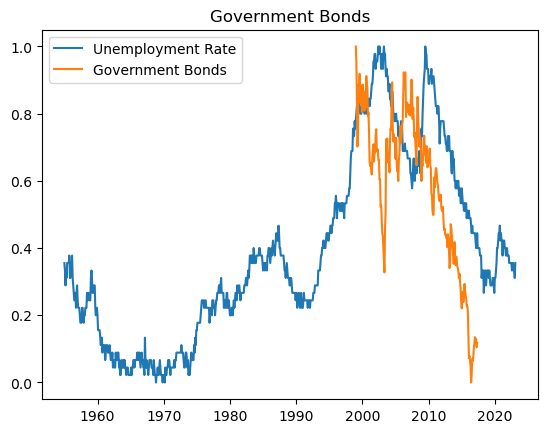

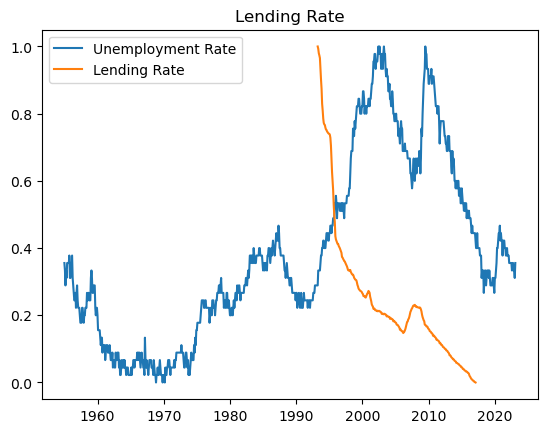

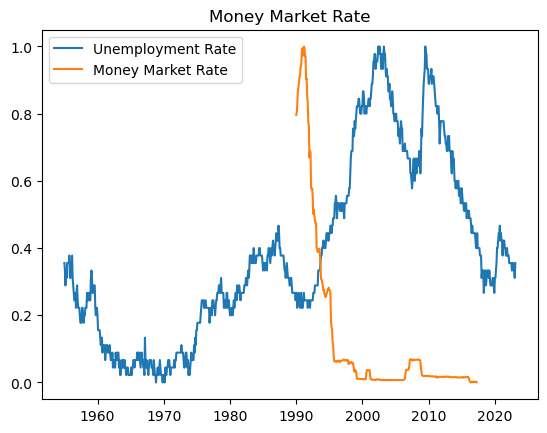

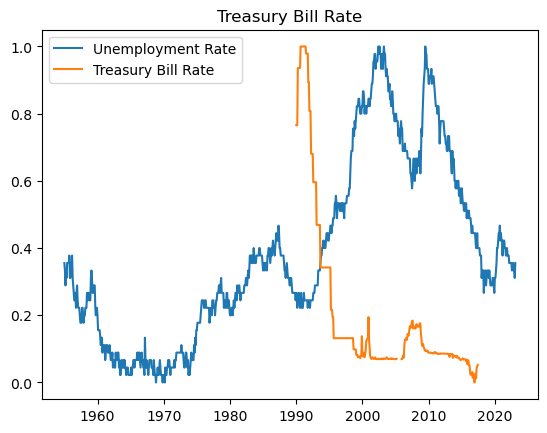

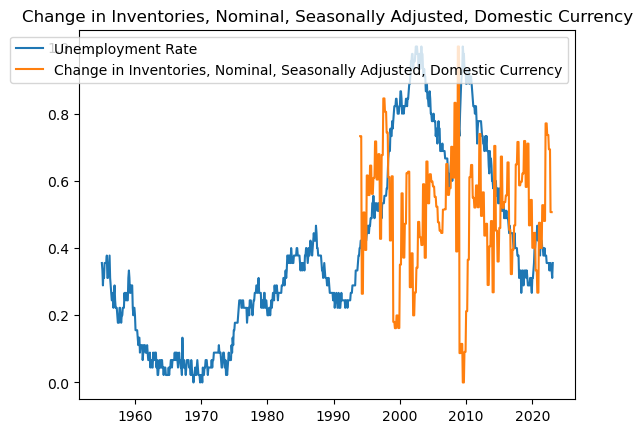

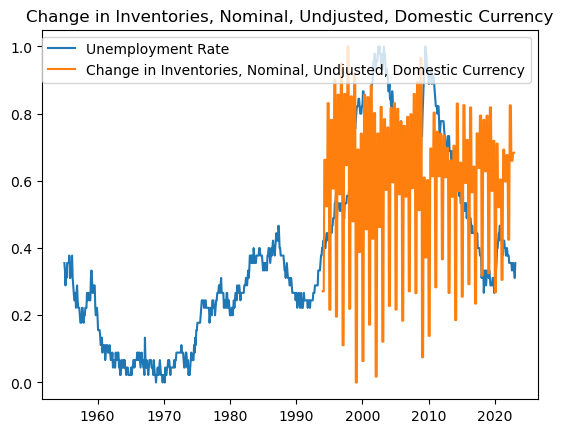

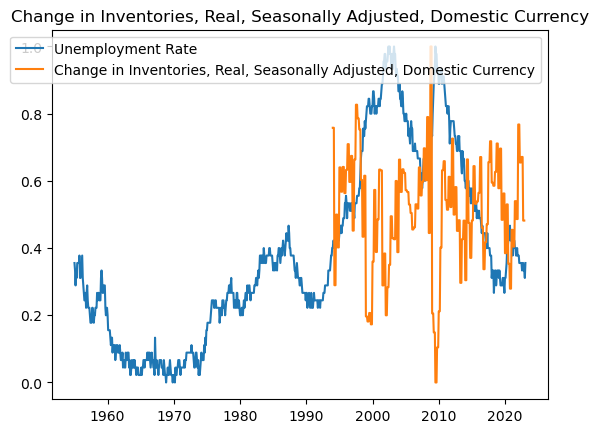

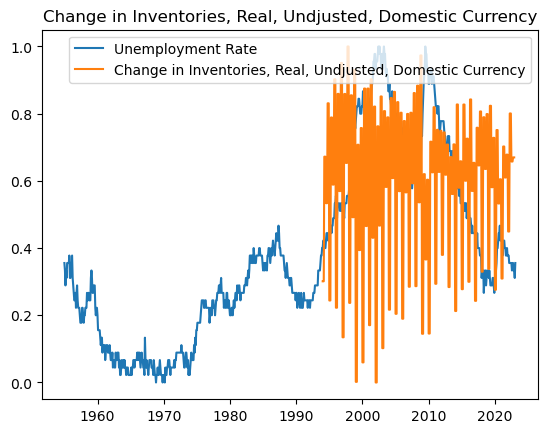

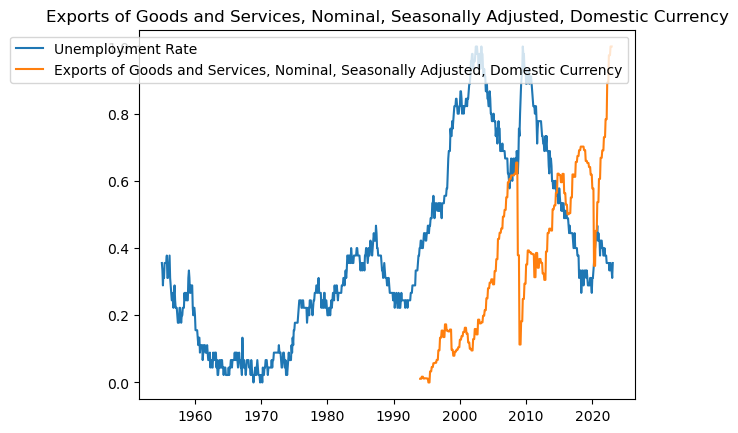

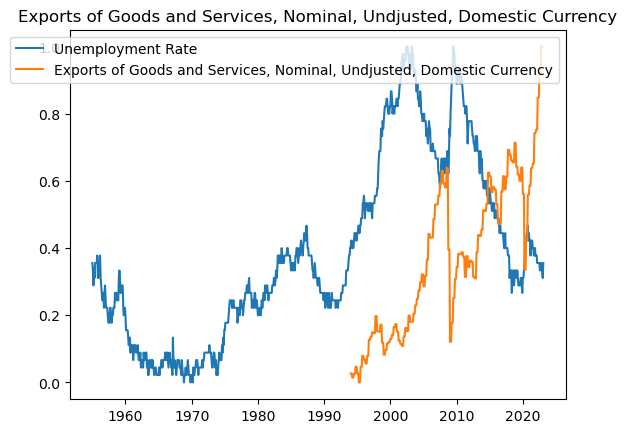

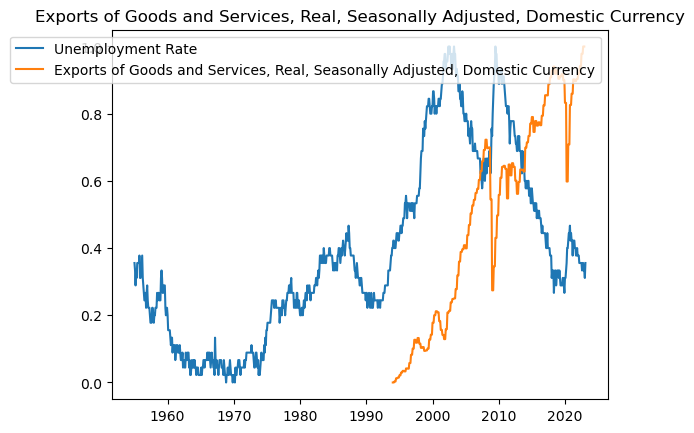

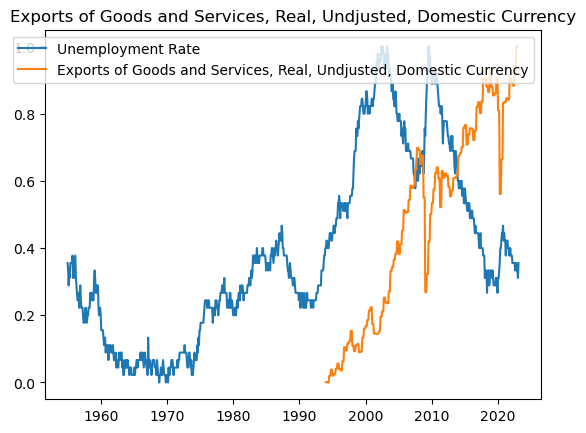

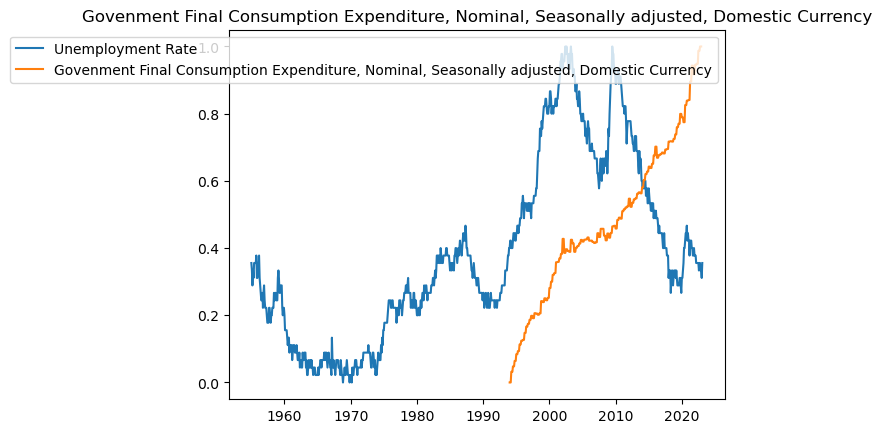

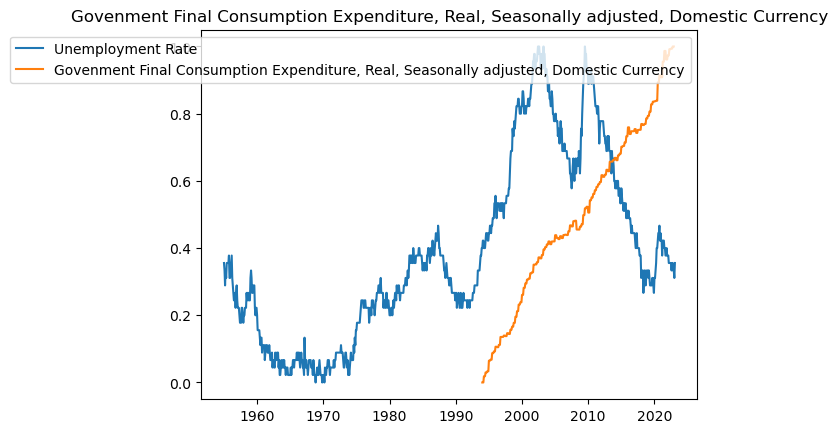

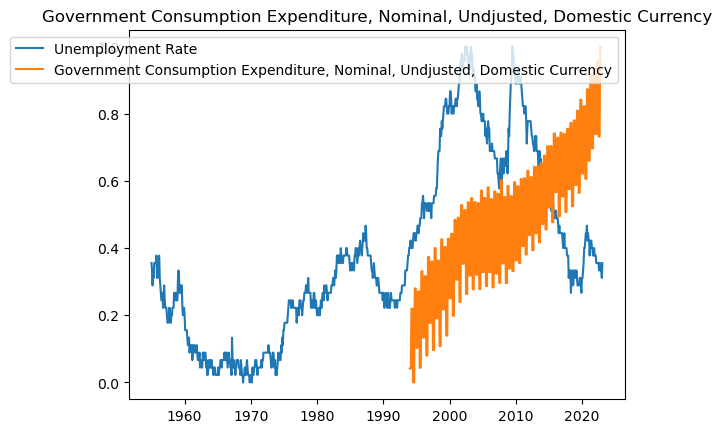

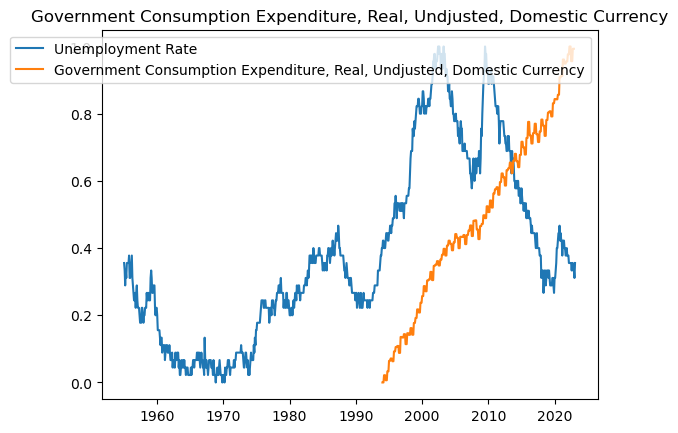

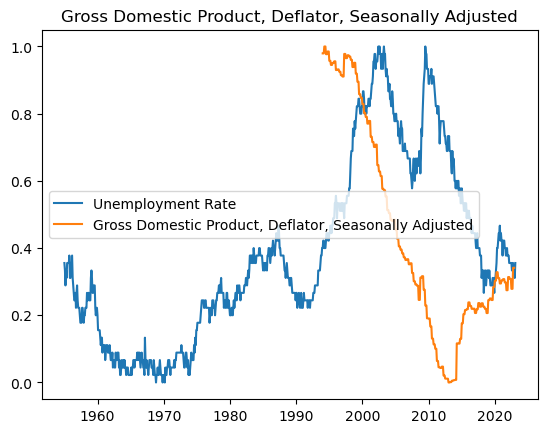

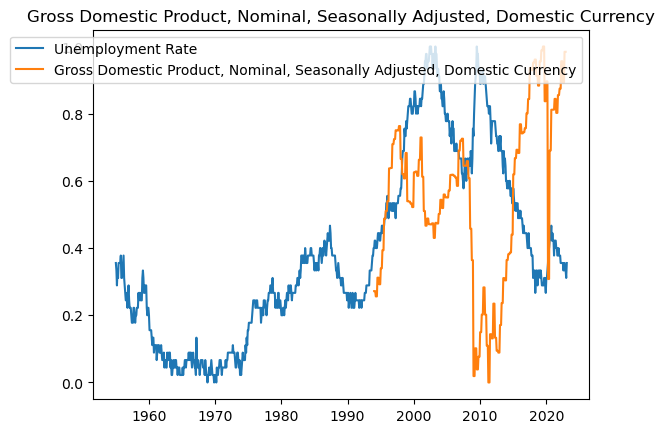

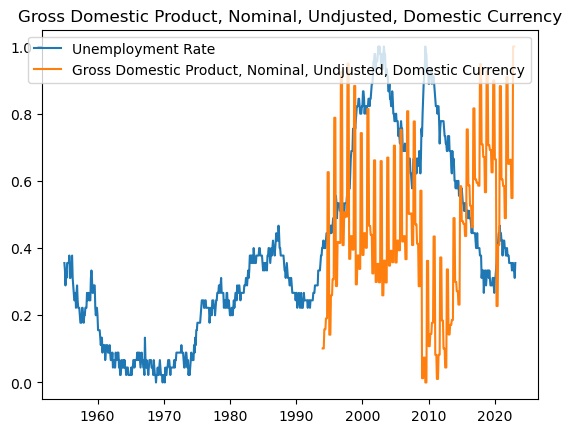

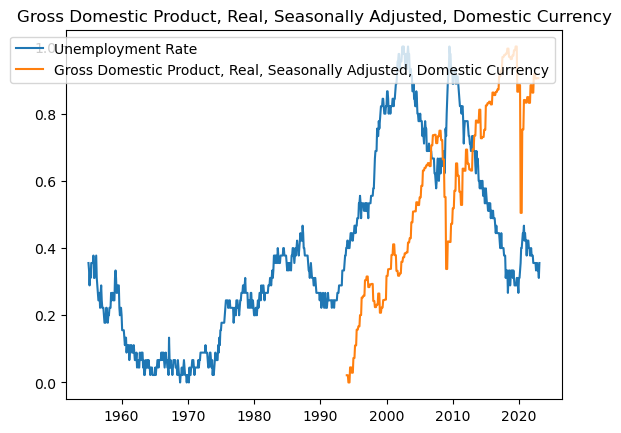

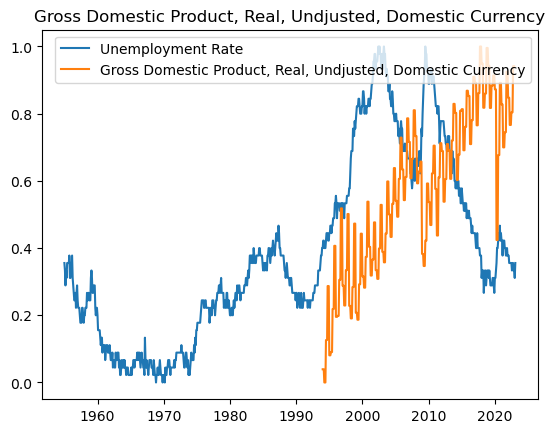

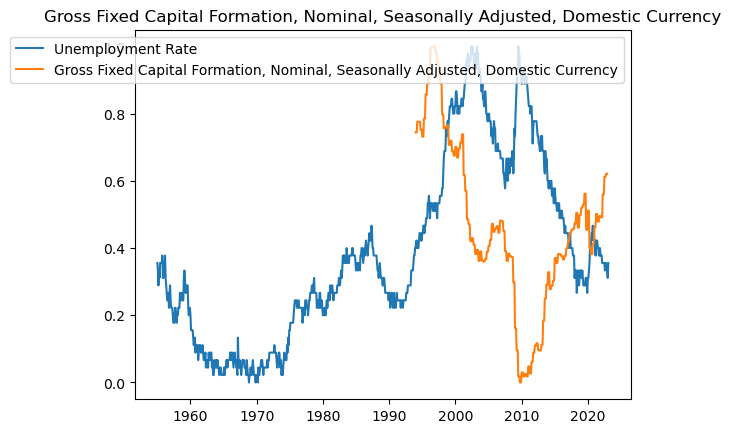

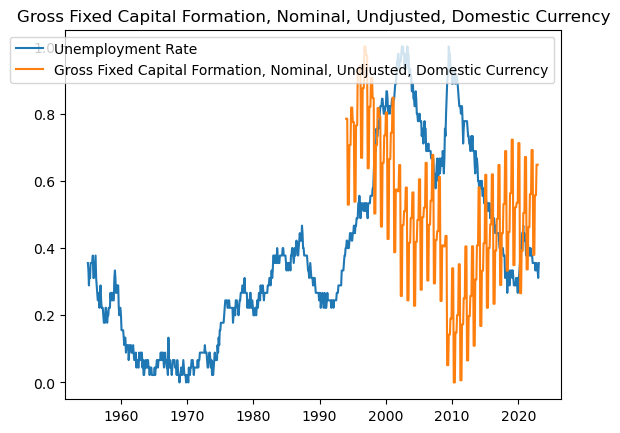

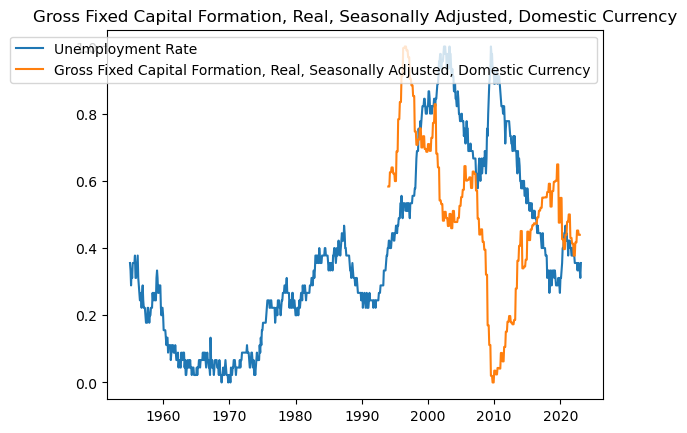

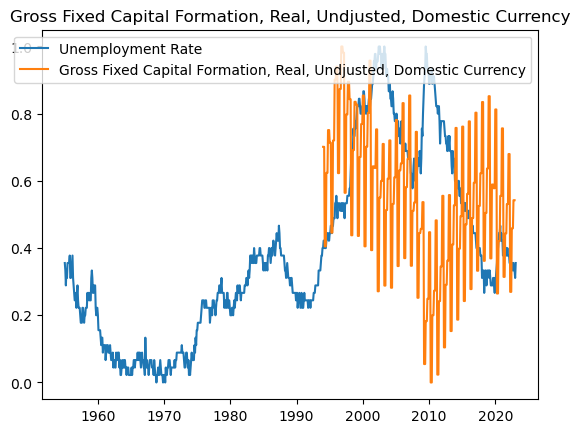

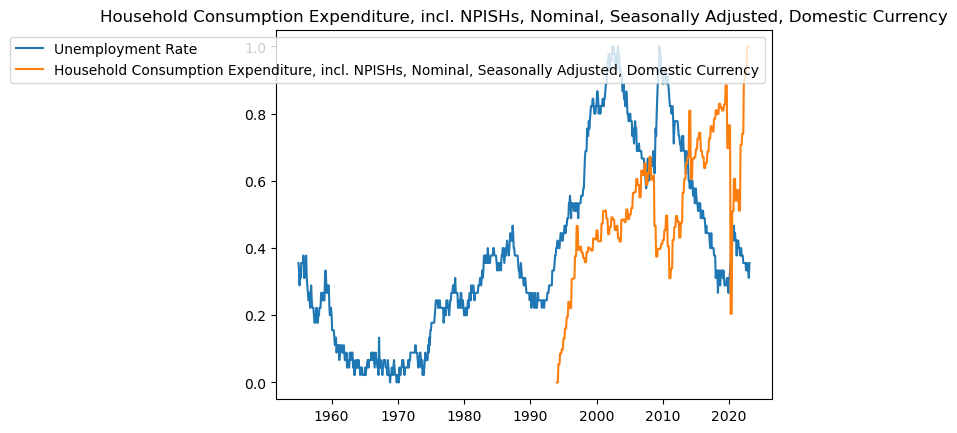

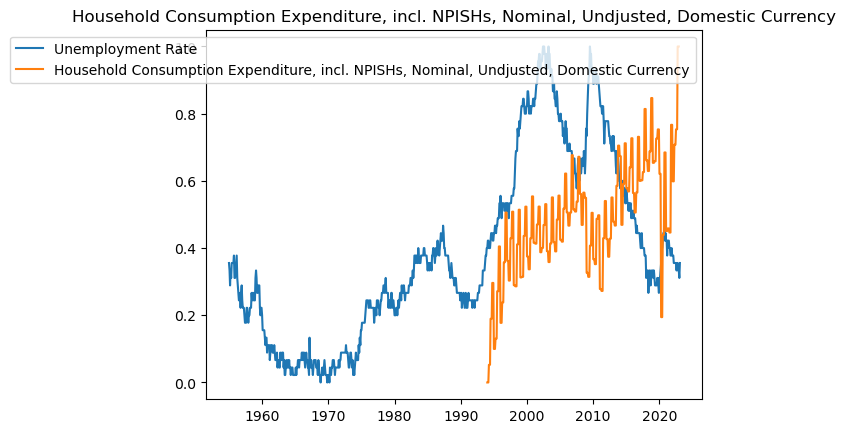

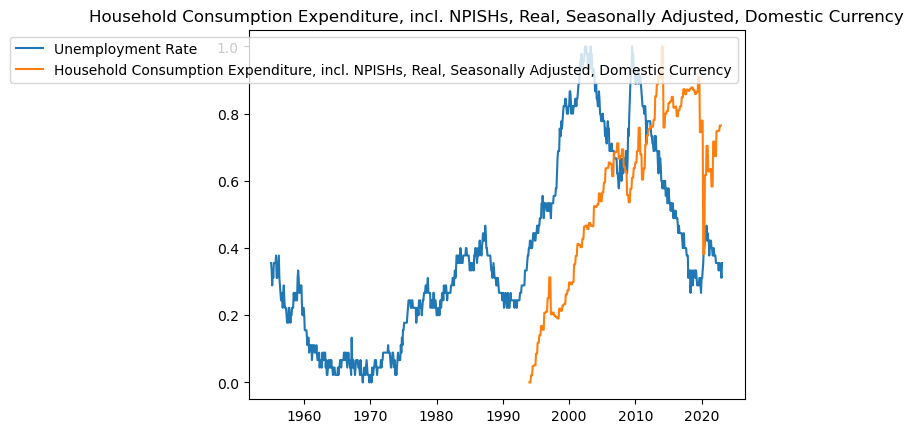

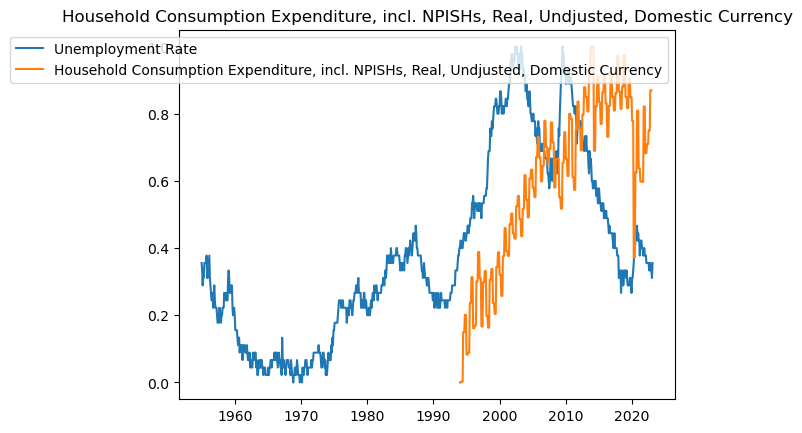

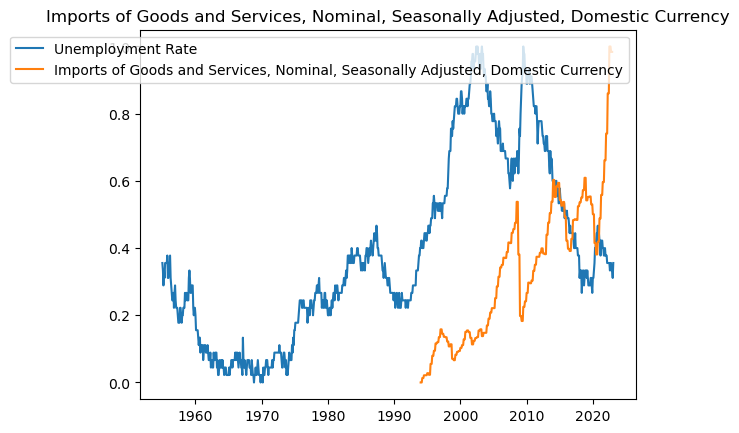

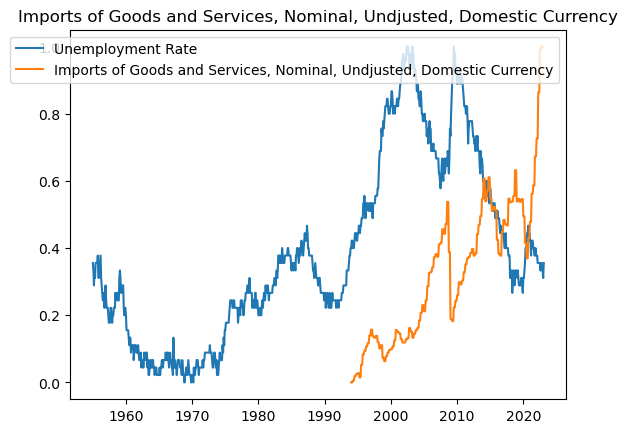

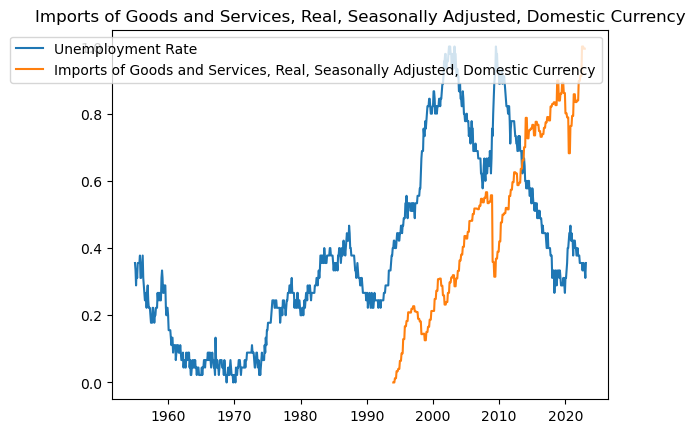

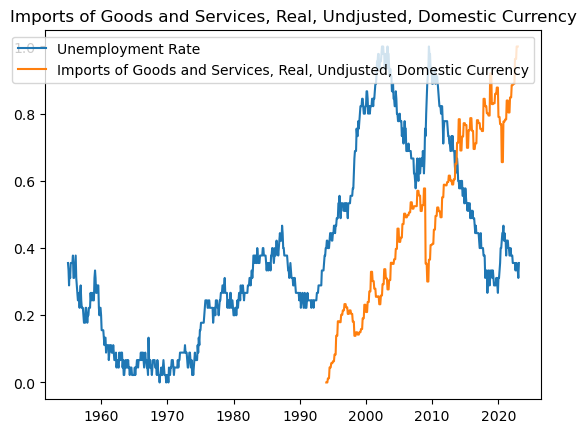

In [20]:
for col in df_MRD_scaled.columns:
    if col!='Value':
        plt.plot(df_MRD_scaled['Value'],label='Unemployment Rate')
        plt.plot(figsize=(15,5))
        plt.plot(df_MRD_scaled[col],label=col)
        plt.title(col)
        plt.legend()
        plt.show()

In [21]:
for col in df_MRD_scaled.columns:
    max_time=df_MRD_scaled[~df_MRD_scaled[col].isna()].index[-1]
    print('%s : %s'%(col,max_time))

Economic Activity, Industrial Production, Index : 2022-11-01 00:00:00
Economic Activity, Industrial Production, Manufacturing, Index : 2022-11-01 00:00:00
Financial Market Prices, Equities, Index : 2017-04-01 00:00:00
Industrial Production, Seasonally adjusted, Index : 2022-11-01 00:00:00
Labor Markets, Wage Rates, Index : 2019-02-01 00:00:00
Prices, Consumer Price Index, All items, Index : 2023-02-01 00:00:00
Value : 2023-02-01 00:00:00
Producer Price Index : 2022-12-01 00:00:00
Business Confidence Index : 2022-12-01 00:00:00
Consumer Confidence Index : 2023-02-01 00:00:00
Central Bank Policy Rate : 2022-08-01 00:00:00
Deposit Rate : 2017-03-01 00:00:00
Discount Rate : 2017-04-01 00:00:00
Government Bonds : 2017-05-01 00:00:00
Lending Rate : 2017-02-01 00:00:00
Money Market Rate : 2017-04-01 00:00:00
Treasury Bill Rate : 2017-06-01 00:00:00
Change in Inventories, Nominal, Seasonally Adjusted, Domestic Currency : 2022-12-01 00:00:00
Change in Inventories, Nominal, Undjusted, Domestic C

In [22]:
col_not_available=['Financial Market Prices, Equities, Index','Central Bank Policy Rate','Deposit Rate',
                   'Discount Rate','Lending Rate', 'Money Market Rate','Treasury Bill Rate']
                   
col_not_available_high_correlation=['Labor Markets, Wage Rates, Index','Government Bonds']

# seasonally_adjusted_col=[col for col in df_MRD_scaled.columns if re.search(r'Seasonally Adjusted',col,re.I)]
                   
df_MRD.drop(columns=col_not_available + col_not_available_high_correlation,inplace=True)

## 2.2. Modelling

### 2.2.1. Reframe time series to supervised learning

In [46]:
df_MRD.to_excel(r'E:\Jupyter notebooks\hackathon23_somnolence\LSTM\Datasets\Japan_LSTM_MRD.xlsx')

In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=False):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [25]:
reframed_dataset = series_to_supervised(df_MRD, 5, 1)

### 2.2.2. Feature Selection

#### 2.2.2.1.Feature selection based on availability

In [26]:
# tlag_col=[col for col in reframed_dataset.columns if re.search(r't\)',col,re.I)==None]
# reframed_dataset_final=reframed_dataset[tlag_col+['var5(t)']]

tlag_col=[col for col in reframed_dataset.columns if re.search(r't-5',col,re.I)!=None]
reframed_dataset_final=reframed_dataset[tlag_col+['var5(t-1)','var5(t-2)','var5(t-3)','var5(t-4)']+['var5(t)']]

reframed_dataset_final.dropna(inplace=True)
reframed_dataset_final

C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_3324\564800525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed_dataset_final.dropna(inplace=True)


,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),...,var33(t-5),var34(t-5),var35(t-5),var36(t-5),var37(t-5),var5(t-1),var5(t-2),var5(t-3),var5(t-4),var5(t)
TIME,,,,,,,,,,,,,,,,,,,,,
1994-06-01,85.650902,85.736954,91.960493,100.811292,2.8,110.7859,97.576013,99.635662,851125.0,-2451500.0,...,60871500.0,8483350.0,8534500.0,11369025.0,11239400.0,2.8,2.8,2.9,2.9,2.8
1994-07-01,90.829793,91.580366,92.749853,100.811292,2.9,110.5802,97.567218,99.926109,851125.0,-2451500.0,...,60871500.0,8483350.0,8534500.0,11369025.0,11239400.0,2.8,2.8,2.8,2.9,2.9
1994-08-01,106.665251,108.405362,93.736554,101.225727,2.9,110.2716,97.605429,100.142278,851125.0,-2451500.0,...,60871500.0,8483350.0,8534500.0,11369025.0,11239400.0,2.9,2.8,2.8,2.8,3.0
1994-09-01,94.116398,95.811802,94.624584,101.432944,2.8,110.0659,97.709832,100.325514,-639050.0,788200.0,...,60916700.0,8881025.0,8697100.0,11582025.0,11451800.0,3.0,2.9,2.8,2.8,3.0
1994-10-01,88.638724,89.968390,94.525914,101.536553,2.8,110.0659,97.855664,100.502837,-639050.0,788200.0,...,60916700.0,8881025.0,8697100.0,11582025.0,11451800.0,3.0,3.0,2.9,2.8,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,81.715320,81.927714,86.296098,107.365091,2.6,111.0093,100.569173,97.364428,862375.0,2127700.0,...,72738600.0,34221775.0,34378200.0,26738025.0,26593300.0,2.6,2.5,2.6,2.6,2.6
2022-11-01,95.820940,96.592579,93.884706,107.365091,2.6,112.0093,100.545968,97.204655,862375.0,2127700.0,...,72738600.0,34221775.0,34378200.0,26738025.0,26593300.0,2.6,2.6,2.5,2.6,2.5
2022-12-01,96.015501,95.810453,94.565735,107.892424,2.6,112.6094,100.524884,97.077642,726550.0,763600.0,...,73414900.0,38401825.0,38159100.0,28217625.0,27865100.0,2.5,2.6,2.6,2.5,2.5


#### 2.2.2.1.Feature selection using causality test

In [27]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result[1]

def check_stationarity(dataset):
    stationary_fields=[]
    non_stationary_fields=[]
    for col in dataset.columns:
        print('______%s_______'%col)
        p_value=adf_test(dataset[col])
        if p_value<=0.05:
            stationary_fields.append(col)
        else:
            non_stationary_fields.append(col)

    print('Number of stationary fields :%s'%len(stationary_fields))
    print('Number of non stationary fields :%s'%len(non_stationary_fields))
    
    return stationary_fields,non_stationary_fields

In [28]:
stationary_fields,non_stationary_fields=check_stationarity(reframed_dataset_final)

______var1(t-5)_______
ADF Statistics: -2.922331
p-value: 0.042812
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var2(t-5)_______
ADF Statistics: -2.871058
p-value: 0.048819
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var3(t-5)_______
ADF Statistics: -3.686284
p-value: 0.004310
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var4(t-5)_______
ADF Statistics: -0.460083
p-value: 0.899574
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var5(t-5)_______
ADF Statistics: -1.456549
p-value: 0.554886
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var6(t-5)_______
ADF Statistics: -1.367398
p-value: 0.597802
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var7(t-5)_______
ADF Statistics: -3.407139
p-value: 0.010718
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var8(t-5)_______
ADF Statistics: -3.271521
p-value: 0.016200
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var9(t-5)_______
ADF Stati

In [29]:
reframed_dataset_final_transformed = reframed_dataset_final.diff().dropna()
stationary_fields,non_stationary_fields=check_stationarity(reframed_dataset_final_transformed)

______var1(t-5)_______
ADF Statistics: -6.677541
p-value: 0.000000
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var2(t-5)_______
ADF Statistics: -6.818290
p-value: 0.000000
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var3(t-5)_______
ADF Statistics: -8.546241
p-value: 0.000000
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var4(t-5)_______
ADF Statistics: -3.055367
p-value: 0.030037
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var5(t-5)_______
ADF Statistics: -3.426108
p-value: 0.010100
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var6(t-5)_______
ADF Statistics: -7.289821
p-value: 0.000000
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var7(t-5)_______
ADF Statistics: -6.016172
p-value: 0.000000
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var8(t-5)_______
ADF Statistics: -5.108111
p-value: 0.000014
Critical values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
______var9(t-5)_______
ADF Stati

In [30]:
reframed_dataset_final_transformed.drop(columns=non_stationary_fields,inplace=True)

In [31]:
correlated_col=[]
for col in [col for col in reframed_dataset_final_transformed.columns if col!='var5(t)']:
    print('_____________Granger Causality test between Unemployment Rate and %s___________________'%(col))
    granger_ = grangercausalitytests(reframed_dataset_final_transformed[['var5(t)', col]], 4)
    if (granger_[1][0]['ssr_chi2test'][1]<=0.05)|(granger_[2][0]['ssr_chi2test'][1]<=0.05)|(granger_[3][0]['ssr_chi2test'][1]<=0.05)|(granger_[4][0]['ssr_chi2test'][1]<=0.05):
        correlated_col.append(col)

_____________Granger Causality test between Unemployment Rate and var1(t-5)___________________

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5203  , p=0.4712  , df_denom=340, df_num=1
ssr based chi2 test:   chi2=0.5249  , p=0.4688  , df=1
likelihood ratio test: chi2=0.5245  , p=0.4689  , df=1
parameter F test:         F=0.5203  , p=0.4712  , df_denom=340, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4277  , p=0.6523  , df_denom=337, df_num=2
ssr based chi2 test:   chi2=0.8681  , p=0.6479  , df=2
likelihood ratio test: chi2=0.8670  , p=0.6482  , df=2
parameter F test:         F=0.4277  , p=0.6523  , df_denom=337, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7235  , p=0.5385  , df_denom=334, df_num=3
ssr based chi2 test:   chi2=2.2160  , p=0.5288  , df=3
likelihood ratio test: chi2=2.2088  , p=0.5302  , df=3
parameter F test:         F=0.7235  , p=0.5385  , df_denom=334, df_num=3

ssr based F test:         F=5.8026  , p=0.0033  , df_denom=337, df_num=2
ssr based chi2 test:   chi2=11.7775 , p=0.0028  , df=2
likelihood ratio test: chi2=11.5792 , p=0.0031  , df=2
parameter F test:         F=5.8026  , p=0.0033  , df_denom=337, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2767  , p=0.0056  , df_denom=334, df_num=3
ssr based chi2 test:   chi2=13.0989 , p=0.0044  , df=3
likelihood ratio test: chi2=12.8535 , p=0.0050  , df=3
parameter F test:         F=4.2767  , p=0.0056  , df_denom=334, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0405  , p=0.0175  , df_denom=331, df_num=4
ssr based chi2 test:   chi2=12.4926 , p=0.0140  , df=4
likelihood ratio test: chi2=12.2686 , p=0.0155  , df=4
parameter F test:         F=3.0405  , p=0.0175  , df_denom=331, df_num=4
_____________Granger Causality test between Unemployment Rate and var16(t-5)___________________

Granger Causality
number of lags (no zero) 

ssr based F test:         F=0.9331  , p=0.4448  , df_denom=331, df_num=4
ssr based chi2 test:   chi2=3.8340  , p=0.4289  , df=4
likelihood ratio test: chi2=3.8125  , p=0.4320  , df=4
parameter F test:         F=0.9331  , p=0.4448  , df_denom=331, df_num=4
_____________Granger Causality test between Unemployment Rate and var33(t-5)___________________

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2147  , p=0.6434  , df_denom=340, df_num=1
ssr based chi2 test:   chi2=0.2166  , p=0.6417  , df=1
likelihood ratio test: chi2=0.2165  , p=0.6417  , df=1
parameter F test:         F=0.2147  , p=0.6434  , df_denom=340, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2802  , p=0.7558  , df_denom=337, df_num=2
ssr based chi2 test:   chi2=0.5688  , p=0.7525  , df=2
likelihood ratio test: chi2=0.5683  , p=0.7526  , df=2
parameter F test:         F=0.2802  , p=0.7558  , df_denom=337, df_num=2

Granger Causality
number of lags (no zero) 

In [32]:
reframed_dataset_final_features=reframed_dataset_final[correlated_col+['var5(t)']].copy()

In [33]:
reframed_dataset_final_features

,var7(t-5),var8(t-5),var13(t-5),var14(t-5),var15(t-5),var16(t-5),var22(t-5),var24(t-5),var28(t-5),var34(t-5),var5(t-1),var5(t-2),var5(t)
TIME,,,,,,,,,,,,,
1994-06-01,97.576013,99.635662,11247000.0,11251800.0,9438975.0,9315800.0,127532325.0,111569125.0,34941550.0,8483350.0,2.8,2.8,2.8
1994-07-01,97.567218,99.926109,11247000.0,11251800.0,9438975.0,9315800.0,127532325.0,111569125.0,34941550.0,8483350.0,2.8,2.8,2.9
1994-08-01,97.605429,100.142278,11247000.0,11251800.0,9438975.0,9315800.0,127532325.0,111569125.0,34941550.0,8483350.0,2.9,2.8,3.0
1994-09-01,97.709832,100.325514,11375000.0,10983300.0,9490950.0,9298000.0,127253275.0,110955700.0,35374875.0,8881025.0,3.0,2.9,3.0
1994-10-01,97.855664,100.502837,11375000.0,10983300.0,9490950.0,9298000.0,127253275.0,110955700.0,35374875.0,8881025.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,100.569173,97.364428,29533500.0,29233800.0,26587125.0,26144800.0,139654800.0,137018825.0,33248500.0,34221775.0,2.6,2.5,2.6
2022-11-01,100.545968,97.204655,29533500.0,29233800.0,26587125.0,26144800.0,139654800.0,137018825.0,33248500.0,34221775.0,2.6,2.6,2.5
2022-12-01,100.524884,97.077642,31222575.0,30845000.0,27256225.0,26849300.0,138537725.0,136651875.0,33609375.0,38401825.0,2.5,2.6,2.5


### 2.2.3. Split to train-test and reframe

In [34]:
scaler=MinMaxScaler()
reframed_dataset_final_scaled=scaler.fit_transform(reframed_dataset_final_features)
reframed_dataset_final_scaled=pd.DataFrame(reframed_dataset_final_scaled,columns=reframed_dataset_final_features.columns)

reframed_dataset_final_scaled.index=reframed_dataset_final_features.index

In [35]:
reframed_dataset_final_scaled

,var7(t-5),var8(t-5),var13(t-5),var14(t-5),var15(t-5),var16(t-5),var22(t-5),var24(t-5),var28(t-5),var34(t-5),var5(t-1),var5(t-2),var5(t)
TIME,,,,,,,,,,,,,
1994-06-01,0.158379,0.634400,0.011314,0.029045,0.000000,0.001002,0.271911,0.021594,0.583136,0.000000,0.181818,0.181818,0.181818
1994-07-01,0.156587,0.678400,0.011314,0.029045,0.000000,0.001002,0.271911,0.021594,0.583136,0.000000,0.181818,0.181818,0.212121
1994-08-01,0.164371,0.711148,0.011314,0.029045,0.000000,0.001002,0.271911,0.021594,0.583136,0.000000,0.212121,0.181818,0.242424
1994-09-01,0.185637,0.738907,0.017650,0.015739,0.002917,0.000000,0.256160,0.000000,0.625698,0.013292,0.242424,0.212121,0.242424
1994-10-01,0.215343,0.765770,0.017650,0.015739,0.002917,0.000000,0.256160,0.000000,0.625698,0.013292,0.242424,0.242424,0.242424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,0.768077,0.290328,0.916400,0.920156,0.962447,0.948640,0.956134,0.917468,0.416842,0.860285,0.121212,0.090909,0.121212
2022-11-01,0.763350,0.266124,0.916400,0.920156,0.962447,0.948640,0.956134,0.917468,0.416842,0.860285,0.121212,0.121212,0.090909
2022-12-01,0.759055,0.246882,1.000000,1.000000,1.000000,0.988310,0.893084,0.904550,0.452288,1.000000,0.090909,0.121212,0.090909


In [36]:
reframed_dataset_final_scaled_values=reframed_dataset_final_scaled.values

train_limit=reframed_dataset_final_scaled_values.shape[0]-12

train_X=reframed_dataset_final_scaled_values[0:train_limit,:-1]
train_Y=reframed_dataset_final_scaled_values[0:train_limit,-1]

test_X=reframed_dataset_final_scaled_values[train_limit:,:-1]
test_Y=reframed_dataset_final_scaled_values[train_limit:,-1]

In [37]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(333, 1, 12) (333,) (12, 1, 12) (12,)


### 2.2.4. Hyperparameter Tuning using GridSearch

Epoch 1/100
5/5 - 3s - loss: 0.4552 - val_loss: 0.0338 - 3s/epoch - 580ms/step
Epoch 2/100
5/5 - 0s - loss: 0.3939 - val_loss: 0.1235 - 47ms/epoch - 9ms/step
Epoch 3/100
5/5 - 0s - loss: 0.3474 - val_loss: 0.1936 - 47ms/epoch - 9ms/step
Epoch 4/100
5/5 - 0s - loss: 0.3116 - val_loss: 0.2469 - 47ms/epoch - 9ms/step
Epoch 5/100
5/5 - 0s - loss: 0.2834 - val_loss: 0.2852 - 47ms/epoch - 9ms/step
Epoch 6/100
5/5 - 0s - loss: 0.2602 - val_loss: 0.3112 - 47ms/epoch - 9ms/step
Epoch 7/100
5/5 - 0s - loss: 0.2425 - val_loss: 0.3234 - 34ms/epoch - 7ms/step
Epoch 8/100
5/5 - 0s - loss: 0.2302 - val_loss: 0.3210 - 47ms/epoch - 9ms/step
Epoch 9/100
5/5 - 0s - loss: 0.2204 - val_loss: 0.3069 - 62ms/epoch - 12ms/step
Epoch 10/100
5/5 - 0s - loss: 0.2115 - val_loss: 0.2844 - 62ms/epoch - 12ms/step
Epoch 11/100
5/5 - 0s - loss: 0.2031 - val_loss: 0.2581 - 49ms/epoch - 10ms/step
Epoch 12/100
5/5 - 0s - loss: 0.1951 - val_loss: 0.2309 - 44ms/epoch - 9ms/step
Epoch 13/100
5/5 - 0s - loss: 0.1874 - val_los

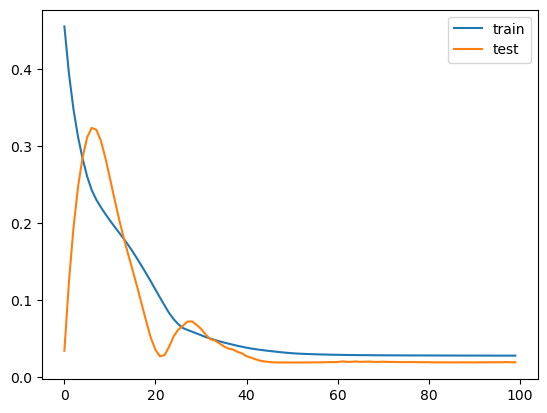

In [38]:
# Fitting model without any hyperparameter tuning
model_no_tuned = Sequential()
model_no_tuned.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model_no_tuned.add(Dense(1))
model_no_tuned.compile(loss='mae', optimizer='adam')
# fit network
history = model_no_tuned.fit(train_X, train_Y, epochs=100, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
# make a prediction
yhat = model_no_tuned.predict(test_X)

# invert scaling for forecast
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((test_X_reshaped, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_Y_reshaped = test_Y.reshape((len(test_Y), 1))
inv_y = concatenate((test_X_reshaped,test_Y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

1/1 [==============================] - 0s 466ms/step


In [40]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %s' % rmse)

Test RMSE: 0.07757647741414982


In [41]:
# Fitting best model using hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    model.add(LSTM(hp.Int('input_unit',min_value=10,max_value=500,step=1),return_sequences=True, 
                   input_shape=(train_X.shape[1],train_X.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=10,max_value=500,step=1),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=10,max_value=500,step=1)))
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.99,step=0.1)))
    
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['sigmoid','relu','tanh','linear','selu','elu'],
                                            default='relu')))
    
    model.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),metrics =['mse'])
    return model

tuner= GridSearch(
        build_model,
        objective='mse',
        max_trials=10,
        executions_per_trial=1,
        overwrite=True,
        project_name='keras_tuning_Japan_LSTM'
        )

tuner.search(
        x=train_X,
        y=train_Y,
        epochs=100,
        batch_size=72,
        validation_data=(test_X,test_Y),
)

Trial 10 Complete [00h 00m 27s]
mse: 0.001101756002753973

Best mse So Far: 0.001101756002753973
Total elapsed time: 00h 06m 20s
INFO:tensorflow:Oracle triggered exit


In [42]:
best_model = tuner.get_best_models(num_models=1)[0]

In [43]:
# make a prediction
yhat = best_model.predict(test_X)

# invert scaling for forecast
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((test_X_reshaped, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_Y_reshaped = test_Y.reshape((len(test_Y), 1))
inv_y = concatenate((test_X_reshaped,test_Y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

1/1 [==============================] - 1s 1s/step


In [44]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %s' % rmse)

Test RMSE: 0.07528749741144826
